# Exploratory Analysis
This notebook just contains misc data exploring.
Run the snakemake workflow prior to this notebook.

In [115]:
DATA_DIR = "/home/jack/unm_gra/data/LAA/Homosapiens-SINGLEPROTEIN-1100"

## Setup

In [116]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Plot Promiscuity Degree (PD) Data
Promiscuity Degree = Number of unique targets a given ligand (i.e., compound) was active against. This is the same definition used in https://pubs.acs.org/doi/10.1021/acsomega.8b02998

In [117]:
activity_df = pl.read_csv(os.path.join(DATA_DIR, "activities", "activity_info.tsv"), separator="\t")
assay_df = pl.read_csv(os.path.join(DATA_DIR, "assays", "assay_info.tsv"), separator="\t")

In [118]:
joined = activity_df.join(assay_df, on="assay_id", how="inner")
mol2tid_df = joined.select(["molregno", "tid"]).unique()
pd_df = (
    mol2tid_df
    .group_by("molregno")
    .agg(pl.count("tid").alias("promiscuity_degree"))
)

<Axes: xlabel='promiscuity_degree', ylabel='Count'>

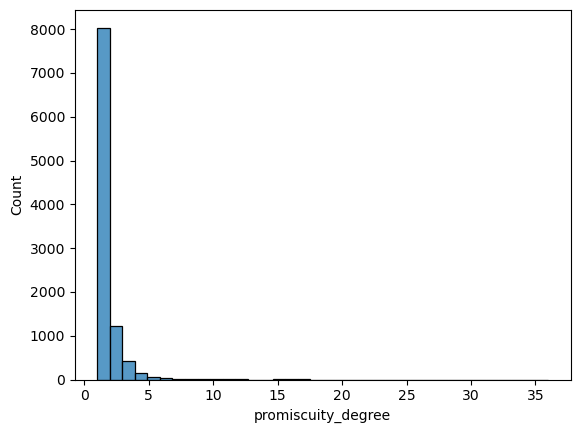

In [119]:
sns.histplot(pd_df, x="promiscuity_degree", bins=max(pd_df["promiscuity_degree"]))

In [120]:
breaks = [1, 4]
labels = ["1", "2-4", "≥5"]
pd_df = pd_df.with_columns(pl.col("promiscuity_degree").cut(breaks=breaks, labels=labels).alias("PD_bin"))
bin_counts = pd_df["PD_bin"].value_counts(sort=False)
bin_counts

PD_bin,count
cat,u32
"""1""",8036
"""2-4""",1803
"""≥5""",156


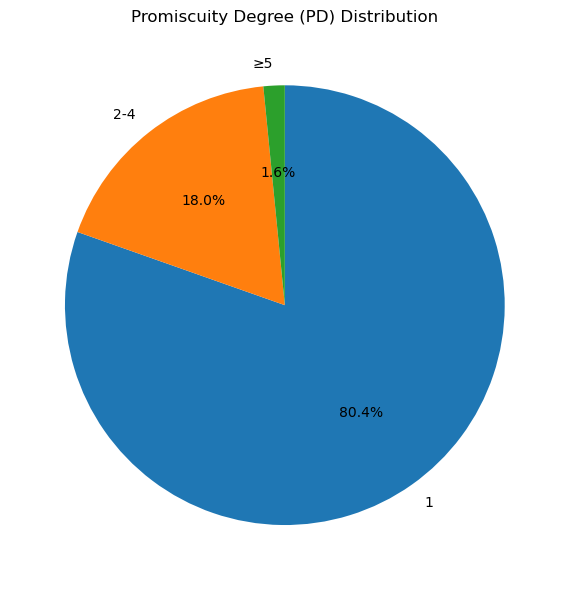

In [121]:
pie_labels, pie_counts = bin_counts["PD_bin"], bin_counts["count"]
plt.figure(figsize=(6, 6))
plt.pie(
    pie_counts,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=90, 
    counterclock=False
)
plt.title("Promiscuity Degree (PD) Distribution")
plt.tight_layout()
plt.show()

## KinMap Visualizations
Gathering info on number of assays, number of unique active compounds for KinMap
visuals.
http://www.kinhub.org/kinmap/

*Note*: To download KinMap images you have to select "SVG" and then edit the data using the fix here: https://askubuntu.com/a/1265209 

In [122]:
def prepare_kinmap_df_with_bins(
    df: pl.DataFrame,
    colname: str,
    cutoffs: list[int],
    colors: list[str],
    min_size: int = None, 
    max_size: int = None  # Optional cap on 'size'
) -> pl.DataFrame:
    """
    Prepares a KinMap visualization DataFrame.

    Parameters:
        df: Input DataFrame with at least 'xName' and the specified `colname`.
        colname: Name of the numeric column to use for binning and size.
        cutoffs: List of upper bounds for the bins (must be increasing).
        colors: List of colors, must be len(cutoffs) + 1.
        min_size: Optional minimum value on the 'size' column (e.g., 100 for visualization).
        max_size: Optional cap on the 'size' column (e.g., 100 for visualization).

    Returns:
        A DataFrame with columns: xName, size, fill.
    """
    if len(colors) != len(cutoffs) + 1:
        raise ValueError("Number of colors must be one more than number of cutoffs.")

    col = pl.col(colname)

    # Construct fill color expression based on cutoffs
    expr = pl.when(col < cutoffs[0]).then(pl.lit(colors[0]))
    for i in range(1, len(cutoffs)):
        expr = expr.when(col < cutoffs[i]).then(pl.lit(colors[i]))
    expr = expr.otherwise(pl.lit(colors[-1]))

    # Optional size cap
    max_size = df[col].max() if max_size is None else max_size
    min_size = df[col].min() if min_size is None else min_size
    size_expr = pl.when(col < max_size).then(col).otherwise(max_size)
    size_expr = pl.when(col < min_size).then(pl.when(col == 0).then(0).otherwise(min_size)).otherwise(size_expr)

    return df.select([
        pl.col("xName"),
        size_expr.alias("size"),
        expr.alias("fill")
    ])

In [123]:
kinmap_df = pl.read_csv("../data/kinmap_file.tsv", separator="\t", columns=["xName", "UniprotID"])
kinmap_df = kinmap_df.unique(subset=["UniprotID"])

In [124]:
assert not(kinmap_df["xName"].is_duplicated().any())

In [125]:
target_df = pl.read_csv(os.path.join(DATA_DIR, "targets/target_info.tsv"), separator="\t", columns=["accession", "tid"])
target_df = target_df.rename({"accession": "UniprotID"})
target_df = target_df.unique(subset=["UniprotID"]) # currently there are duplicates bc some targets are assigned to multiple different families

In [126]:
ktarget_df = kinmap_df.join(target_df, on="UniprotID", how="inner")

In [127]:
ktarget_df.head()

xName,UniprotID,tid
str,str,i64
"""EphA5""","""P54756""",30019
"""TYRO3""","""Q06418""",100912
"""EphB2""","""P29323""",11569
"""DAPK3""","""O43293""",10051
"""RIOK1""","""Q9BRS2""",101404


In [128]:
tid2assaycount_df = (
    assay_df
    .group_by("tid")
    .agg(pl.count("assay_id").alias("n_assays"))
)

In [129]:
tid2ligandcount_df = (
    mol2tid_df
    .group_by("tid")
    .agg(pl.count("molregno").alias("n_ligands"))
)

In [130]:
ktarget_df = ktarget_df.join(tid2assaycount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_assays"].fill_null(0))

In [131]:
ktarget_df = ktarget_df.join(tid2ligandcount_df, on="tid", how="left")
ktarget_df = ktarget_df.with_columns(ktarget_df["n_ligands"].fill_null(0))

In [132]:
ktarget_df

xName,UniprotID,tid,n_assays,n_ligands
str,str,i64,u32,u32
"""EphA5""","""P54756""",30019,96,2
"""TYRO3""","""Q06418""",100912,176,10
"""EphB2""","""P29323""",11569,121,1
"""DAPK3""","""O43293""",10051,128,2
"""RIOK1""","""Q9BRS2""",101404,32,0
…,…,…,…,…
"""IGF1R""","""P08069""",234,546,43
"""CK1a""","""P48729""",11720,161,1
"""GPRK6""","""P43250""",102447,60,0


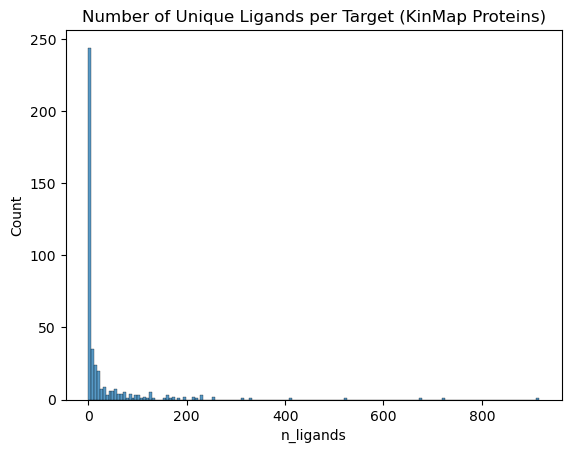

In [133]:
sns.histplot(ktarget_df, x="n_ligands")
plt.title("Number of Unique Ligands per Target (KinMap Proteins)")
plt.show()

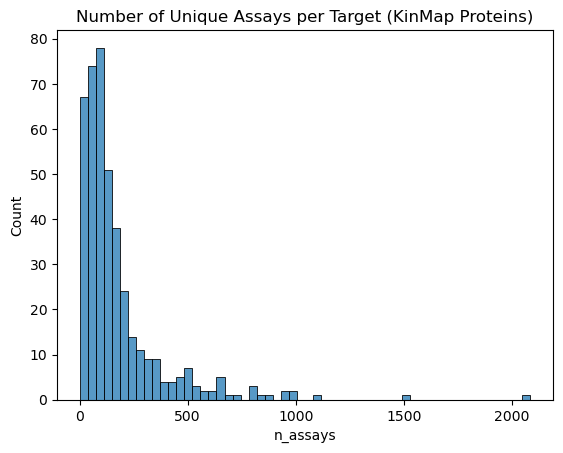

In [134]:
sns.histplot(ktarget_df, x="n_assays")
plt.title("Number of Unique Assays per Target (KinMap Proteins)")
plt.show()

In [135]:
def create_kinmap_csv(df: pl.DataFrame, col: str, size_cutoffs: list, colors: list, save_pth: str):
    # just fixing size for easier vis
    kinmap_csv_df = prepare_kinmap_df_with_bins(df, col, size_cutoffs, colors, max_size=15, min_size=15)
    kinmap_csv_df.write_csv(save_pth)

In [136]:
# save n_assay data
size_cutoffs = [5, 50, 100]
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
print(colors)
pth = os.path.join(DATA_DIR, "addl_files/kinmap_nassay_vis.csv")
create_kinmap_csv(ktarget_df, "n_assays", size_cutoffs, colors, pth)

['#414487', '#2a788e', '#22a884', '#7ad151']


In [137]:
# save n_ligand data
size_cutoffs = [5, 50, 100] # 1-4, 5-49, 50-99, 100+
colors = sns.color_palette("viridis", len(size_cutoffs) + 1).as_hex() # maps sizes to color
pth = os.path.join(DATA_DIR, "addl_files/kinmap_nligand_vis.csv")
create_kinmap_csv(ktarget_df, "n_ligands", size_cutoffs, colors, pth)

In [138]:
# save main df
ktarget_df.write_csv(os.path.join(DATA_DIR, "addl_files/kinmap_data.csv"))

## Define Plot Functions

In [139]:
def bar_plot(pl_counts, x: str, y: str, bar_title: str, xlabel: str, ylabel: str, ax=None, colors=None, order:list=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    if colors is None:
        colors = sns.color_palette("hls", len(pl_counts))
    if order is not None:
        pl_counts = pl_counts.sort(pl.col(x).sort_by(pl.Series(order)))
    sns.barplot(data=pl_counts, x=x, y=y, ax=ax, palette=colors, order=order)
    ax.set_title(bar_title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    m = pl_counts[y].max()
    for i, v in enumerate(pl_counts[y]):
        ax.text(i, v + m * 0.01, 
                str(v), ha='center', va='bottom', fontweight='bold')
    

In [140]:
def pie_bar_plot(pl_counts, x: str, y: str, bar_title: str, pie_title: str, xlabel: str, ylabel: str, order: list = None):
    # Set up the plotting style
    plt.style.use('default')
    colors = sns.color_palette("hls", len(pl_counts))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart
    bar_plot(pl_counts, x, y, bar_title, xlabel, ylabel, ax1, colors, order)

    # Pie chart
    if order is not None:
        pl_counts = pl_counts.sort(pl.col(x).sort_by(pl.Series(order)))
    wedges, texts = ax2.pie(pl_counts[y], 
                                    labels=None,
                                    colors=colors,
                                    startangle=90)

    ax2.set_title(pie_title, fontsize=14, fontweight='bold')

    # Enhance pie chart text
    total_y = pl_counts[y].sum()
    legend_labels = []
    for cluster, count in pl_counts.iter_rows():
        percentage = (count / total_y) * 100
        legend_labels.append(f'{cluster}: {percentage:.1f}% ({count})')

    ax2.legend(wedges, legend_labels, title="Legend", 
            loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Summary of distribution:")
    print(pl_counts)
    print(f"Total {y}: {total_y}")
    print(f"Average {y} per {x}: {pl_counts[y].mean():.1f}")

In [141]:
def plot_multi_hist(df: pl.DataFrame, 
                    cluster_order: list, 
                    cluster_col: str = "short_name", 
                    count_col: str = "count", 
                    xlabel: str = "N. Unique Assays", 
                    title: str  = "Distribution of N. Assays by Protein Kinase Group",
                    n_row: int = 3,
                    n_col: int = 3):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    axes_flat = axes.flatten()
    colors = sns.color_palette("hls", len(cluster_order))
    min_count = 0

    for i, cluster_name in enumerate(cluster_order):
        cluster_data = df.filter(pl.col(cluster_col) == cluster_name)
        counts = cluster_data[count_col].to_numpy()
        
        ax = axes_flat[i]
        n_bins = min(len(counts), 50)
        sns.histplot(data=counts, bins=n_bins, stat="percent", ax=ax, alpha=0.8, color=colors[i])
        
        ax.set_title(f'{cluster_name}', fontweight='bold')
        ax.set_xbound(lower=min_count)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Percent')
        
        mean_count = np.mean(counts)
        median_count = np.median(counts)
        zero_count = (counts == 0).sum()
        lt10_count = (counts < 10).sum()
        n_samples = len(counts)
        
        stats_text = f'n={n_samples}\nMean: {mean_count:.1f}\nMedian: {median_count:.1f}\nCounts = 0: {zero_count}\nCounts < 10: {lt10_count}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [166]:
def create_multi_scatter_plots(df: pl.DataFrame, 
                            cluster_order: list, 
                            cluster_col: str = "short_name", 
                            x_col: str = "threshold", 
                            y_col: str = "enrichment_factor",
                            xlabel: str  = "Similarity Threshold",
                            ylabel: str = "Enrichment Factor",
                            title: str = "Enrichment Factor vs Similarity Threshold by Kinase Group",
                            connect_points: bool = True,
                            show_all_xticks: bool = True,
                            correlation_method: str = "spearman",
                            show_parity_line: bool = False,
                            n_row: int = 3,
                            n_col: int = 3):
    
    sns.set_style("whitegrid")
    plt.style.use('default')

    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    colors = sns.color_palette("hls", len(cluster_order))

    # Create plots for each cluster
    for i, cluster in enumerate(cluster_order):
        # Calculate subplot position
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Filter data for this cluster
        cluster_data = df.filter(df[cluster_col] == cluster).sort(x_col)
        
        # Create scatter plot with different colors for each threshold
        ax.scatter(cluster_data[x_col], cluster_data[y_col], 
                    color=colors[i], s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
        
        # Connect points with a line
        if connect_points:
            ax.plot(cluster_data[x_col], cluster_data[y_col], color='gray', alpha=0.6, linewidth=1, linestyle='-')
        
        # Customize the subplot
        ax.set_title(f'{cluster}', fontsize=12, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Set x-axis to show all threshold values
        if show_all_xticks:
            ax.set_xticks(sorted(df[x_col].unique()))
        
        # Add some padding to y-axis
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min * 0.95, y_max * 1.05)

        # add correlation text
        if correlation_method is not None:
            correlation = cluster_data.select(pl.corr(x_col, y_col, method=correlation_method)).item()
            if correlation_method == "spearman":
                corr_symbol = r"$\rho$"
            else:
                corr_symbol = "r"
            ax.text(0.05, 0.95, corr_symbol + f" = {correlation:.3f}", 
                    transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
        # add parity line if requested
        if show_parity_line:
            ax.plot(
                [cluster_data[x_col].min(), cluster_data[x_col].max()],
                [cluster_data[y_col].min(), cluster_data[y_col].max()],
                color = "black",
                linestyle='dashed',
                linewidth=2,
                alpha = 0.5,
            )

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

## Looking at ligands between Kinase Groups
Class_level=4 → Group

Class_level=5 → Family

Class_level=6 → SubFamily

More info on Kinase classification here: http://kinase.com/wiki/index.php/Kinase_classification

In [143]:
class_level = 4
ligand_cluster_df = pl.read_csv(os.path.join(DATA_DIR, f"family_clusters/ligand2cluster-class_level={class_level}.tsv"), separator="\t")

In [144]:
family_info_df = pl.read_csv(os.path.join(DATA_DIR,"targets/family_addl_info.tsv"), separator="\t")
# make short_name capitalized
family_info_df = family_info_df.with_columns((pl.col("short_name").str.to_uppercase()))

In [145]:
cluster_order = ['CK1', 'STE', 'ATYPICAL', 'CAMK', 'AGC', 'TKL', 'CMGC', 'OTHER', 'TK'] # this is just so colors match between plots

In [146]:
ligand_cluster_df = ligand_cluster_df.join(family_info_df, on="protein_class_id")
ligand_cluster_df = ligand_cluster_df.unique()
ligand_cluster_df

molregno,tid,protein_class_id,cluster,parent_id,pref_name,short_name,class_level
i64,i64,i64,i64,i64,str,str,i64
385921,10695,1289,4,1100,"""AGC protein kinase group""","""AGC""",4
1819626,101386,1334,7,1100,"""TKL protein kinase group""","""TKL""",4
1521745,11752,1285,3,1100,"""TK protein kinase group""","""TK""",4
333368,10434,1285,3,1100,"""TK protein kinase group""","""TK""",4
370937,12967,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4
…,…,…,…,…,…,…,…
2563109,10938,1285,3,1100,"""TK protein kinase group""","""TK""",4
2754202,10849,1285,3,1100,"""TK protein kinase group""","""TK""",4
2844243,11400,1452,9,1100,"""Atypical protein kinase group""","""ATYPICAL""",4


/tmp/ipykernel_27660/114895822.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pl_counts, x=x, y=y, ax=ax, palette=colors, order=order)


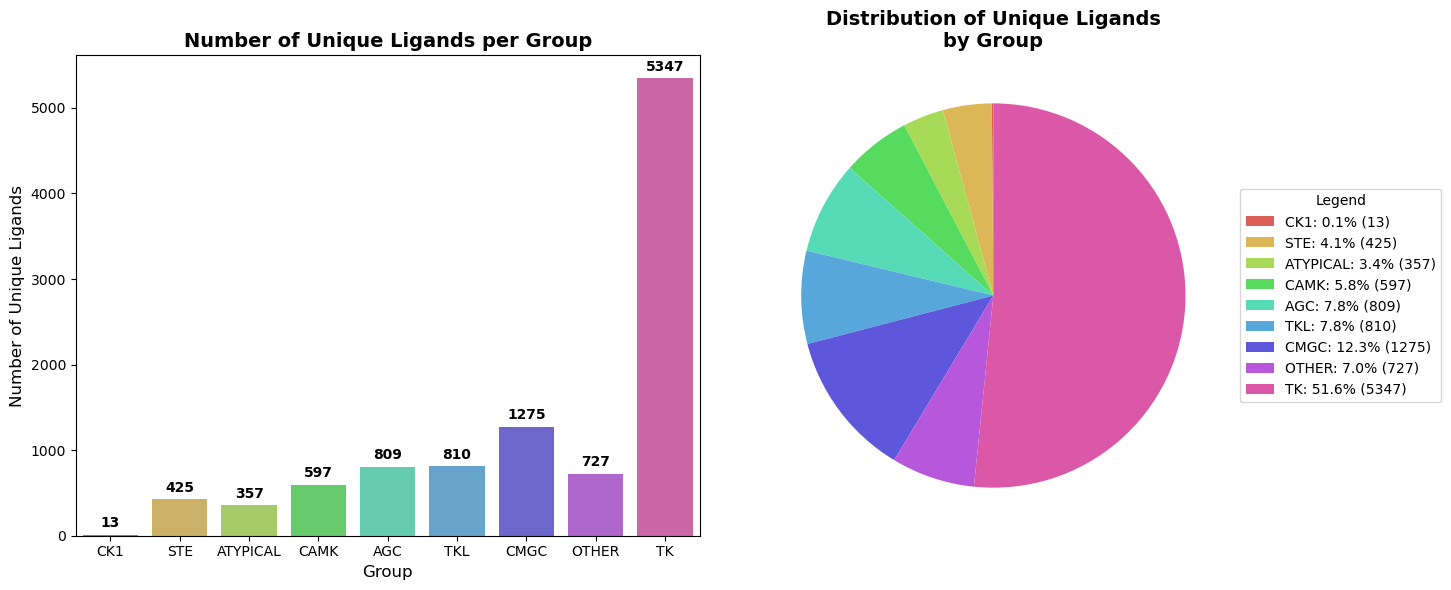

Summary of distribution:
shape: (9, 2)
┌────────────┬────────────────┐
│ short_name ┆ unique_ligands │
│ ---        ┆ ---            │
│ str        ┆ u32            │
╞════════════╪════════════════╡
│ CK1        ┆ 13             │
│ STE        ┆ 425            │
│ ATYPICAL   ┆ 357            │
│ CAMK       ┆ 597            │
│ AGC        ┆ 809            │
│ TKL        ┆ 810            │
│ CMGC       ┆ 1275           │
│ OTHER      ┆ 727            │
│ TK         ┆ 5347           │
└────────────┴────────────────┘
Total unique_ligands: 10360
Average unique_ligands per short_name: 1151.1


In [147]:
bar_title = 'Number of Unique Ligands per Group'
pie_title = 'Distribution of Unique Ligands\nby Group'
x = "short_name"
y = "unique_ligands"
xlabel = 'Group'
ylabel = "Number of Unique Ligands"
# Calculate unique ligands per family cluster
ligand_counts = (ligand_cluster_df
                .group_by(x)
                .agg(pl.col('molregno').n_unique().alias('unique_ligands'))
                .sort(x))
# note that sum is larger than N unique ligands bc some ligands have multiple targets
pie_bar_plot(ligand_counts, x, y, bar_title, pie_title, xlabel, ylabel, order=cluster_order)

In [148]:
class_level = 4
target_cluster_df = pl.read_csv(os.path.join(DATA_DIR, f"family_clusters/target2cluster-class_level={class_level}.tsv"), separator="\t")

In [149]:
target_cluster_df = target_cluster_df.join(family_info_df, on="protein_class_id", how="inner")
target_cluster_df["class_level"].value_counts()

class_level,count
i64,u32
4,429


/tmp/ipykernel_27660/114895822.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pl_counts, x=x, y=y, ax=ax, palette=colors, order=order)


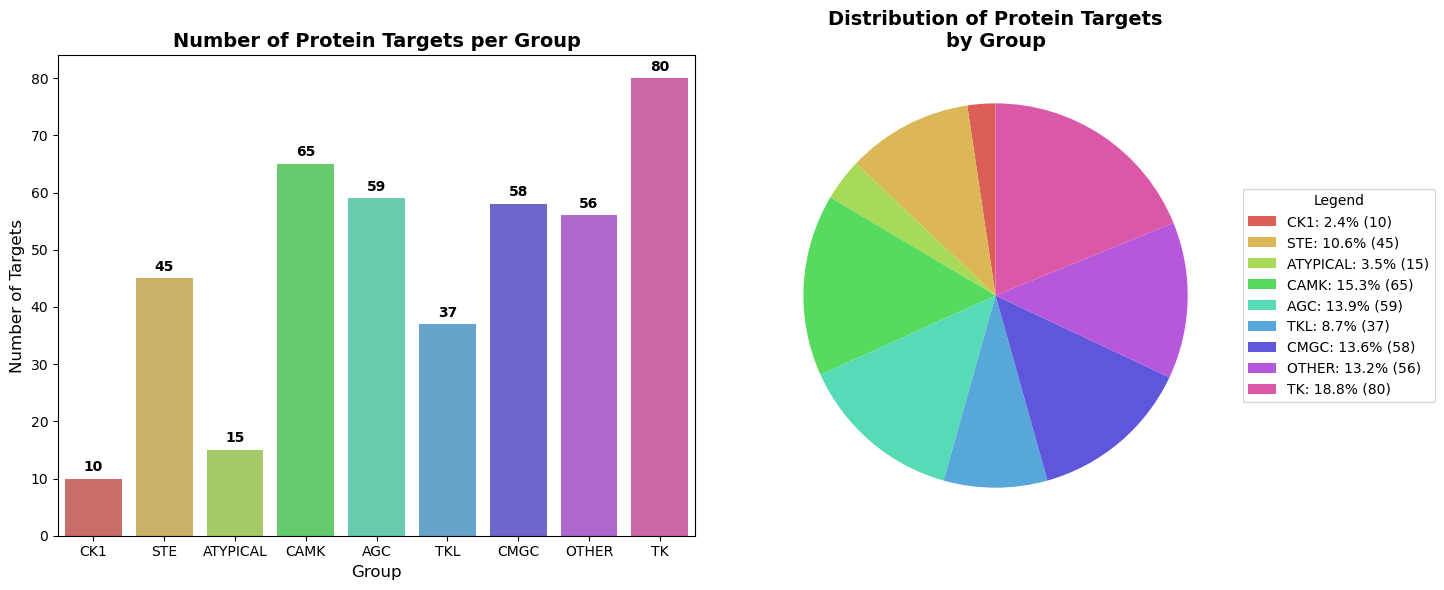

Summary of distribution:
shape: (9, 2)
┌────────────┬────────────┐
│ short_name ┆ unique_tid │
│ ---        ┆ ---        │
│ str        ┆ u32        │
╞════════════╪════════════╡
│ CK1        ┆ 10         │
│ STE        ┆ 45         │
│ ATYPICAL   ┆ 15         │
│ CAMK       ┆ 65         │
│ AGC        ┆ 59         │
│ TKL        ┆ 37         │
│ CMGC       ┆ 58         │
│ OTHER      ┆ 56         │
│ TK         ┆ 80         │
└────────────┴────────────┘
Total unique_tid: 425
Average unique_tid per short_name: 47.2


In [150]:
bar_title = "Number of Protein Targets per Group"
pie_title = "Distribution of Protein Targets\nby Group"
x = "short_name"
y = "unique_tid"
xlabel = "Group"
ylabel = "Number of Targets"
target_counts = (target_cluster_df
                .group_by(x)
                .agg(pl.col('tid').n_unique().alias('unique_tid'))
                .sort(x))
# note that the sum may be larger than total N of targets bc some targets have multiple classifications
pie_bar_plot(target_counts, x, y, bar_title, pie_title, xlabel, ylabel, order=cluster_order)

In [151]:
assay_df["assay_id"].n_unique()

73487

/tmp/ipykernel_27660/114895822.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pl_counts, x=x, y=y, ax=ax, palette=colors, order=order)


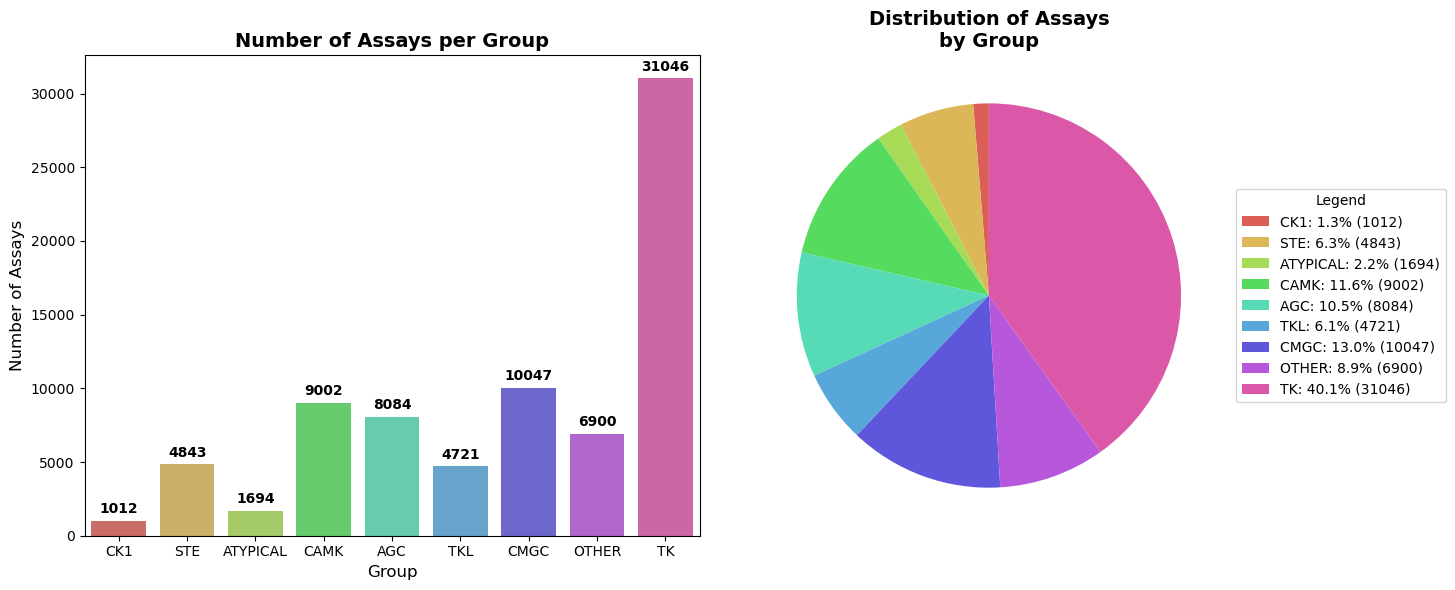

Summary of distribution:
shape: (9, 2)
┌────────────┬─────────────┐
│ short_name ┆ assay_count │
│ ---        ┆ ---         │
│ str        ┆ u32         │
╞════════════╪═════════════╡
│ CK1        ┆ 1012        │
│ STE        ┆ 4843        │
│ ATYPICAL   ┆ 1694        │
│ CAMK       ┆ 9002        │
│ AGC        ┆ 8084        │
│ TKL        ┆ 4721        │
│ CMGC       ┆ 10047       │
│ OTHER      ┆ 6900        │
│ TK         ┆ 31046       │
└────────────┴─────────────┘
Total assay_count: 77349
Average assay_count per short_name: 8594.3


In [152]:
# number of assays per group
tdf = target_cluster_df.join(assay_df["tid"].value_counts(), on="tid")
bar_title = "Number of Assays per Group"
pie_title = "Distribution of Assays\nby Group"
x = "short_name"
y = "assay_count"
xlabel = "Group"
ylabel = "Number of Assays"
target_counts = (tdf
                .group_by(x)
                .agg(pl.col('count').sum().alias('assay_count'))
                .sort(x))
# note that the sum may be larger than total N of assays bc some targets have multiple classifications
pie_bar_plot(target_counts, x, y, bar_title, pie_title, xlabel, ylabel, order=cluster_order)

In [153]:
target_df = pl.read_csv(os.path.join(DATA_DIR, "targets/target_info.tsv"), separator="\t", columns=["accession", "protein_class_id", "tid"])
tfam_df = target_df.join(family_info_df, on="protein_class_id")
tvc = tfam_df["class_level"].value_counts().sort(by="class_level")
tvc # note that some targets are only classified according to highest level of 3 and that some targets have > 1 classification

class_level,count
i64,u32
3,4
4,17
5,242
6,170


In [154]:
cl_n_targets = target_cluster_df["tid"].n_unique()
total_targets = target_df["tid"].n_unique()
print(f"Targets classified at class_level={class_level} or greater:", cl_n_targets)
print("Total targets:", total_targets)

Targets classified at class_level=4 or greater: 419
Total targets: 423


In [155]:
target_cluster_df["tid"].n_unique()

419

In [156]:
ta_df = target_cluster_df.join(assay_df["tid"].value_counts(), on="tid", how="left")
ta_df = ta_df.with_columns(
    pl.when(ta_df["count"].is_null())
    .then(0)
    .otherwise(ta_df["count"]).alias("count")
)
ta_df = ta_df.unique()
ta_df = ta_df.rename({"count": "assay_count"})
assert ta_df["tid"].n_unique() == target_cluster_df["tid"].n_unique()

In [157]:
ta_df.filter(ta_df["tid"].is_duplicated()).sort(by="tid")

tid,protein_class_id,cluster,parent_id,pref_name,short_name,class_level,assay_count
i64,i64,i64,i64,str,str,i64,u32
10782,1289,4,1100,"""AGC protein kinase group""","""AGC""",4,134
10782,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4,134
10850,1289,4,1100,"""AGC protein kinase group""","""AGC""",4,277
10850,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4,277
10929,1289,4,1100,"""AGC protein kinase group""","""AGC""",4,304
…,…,…,…,…,…,…,…
10939,1289,4,1100,"""AGC protein kinase group""","""AGC""",4,122
11843,1339,8,1100,"""CAMK protein kinase group""","""CAMK""",4,167
11843,1289,4,1100,"""AGC protein kinase group""","""AGC""",4,167


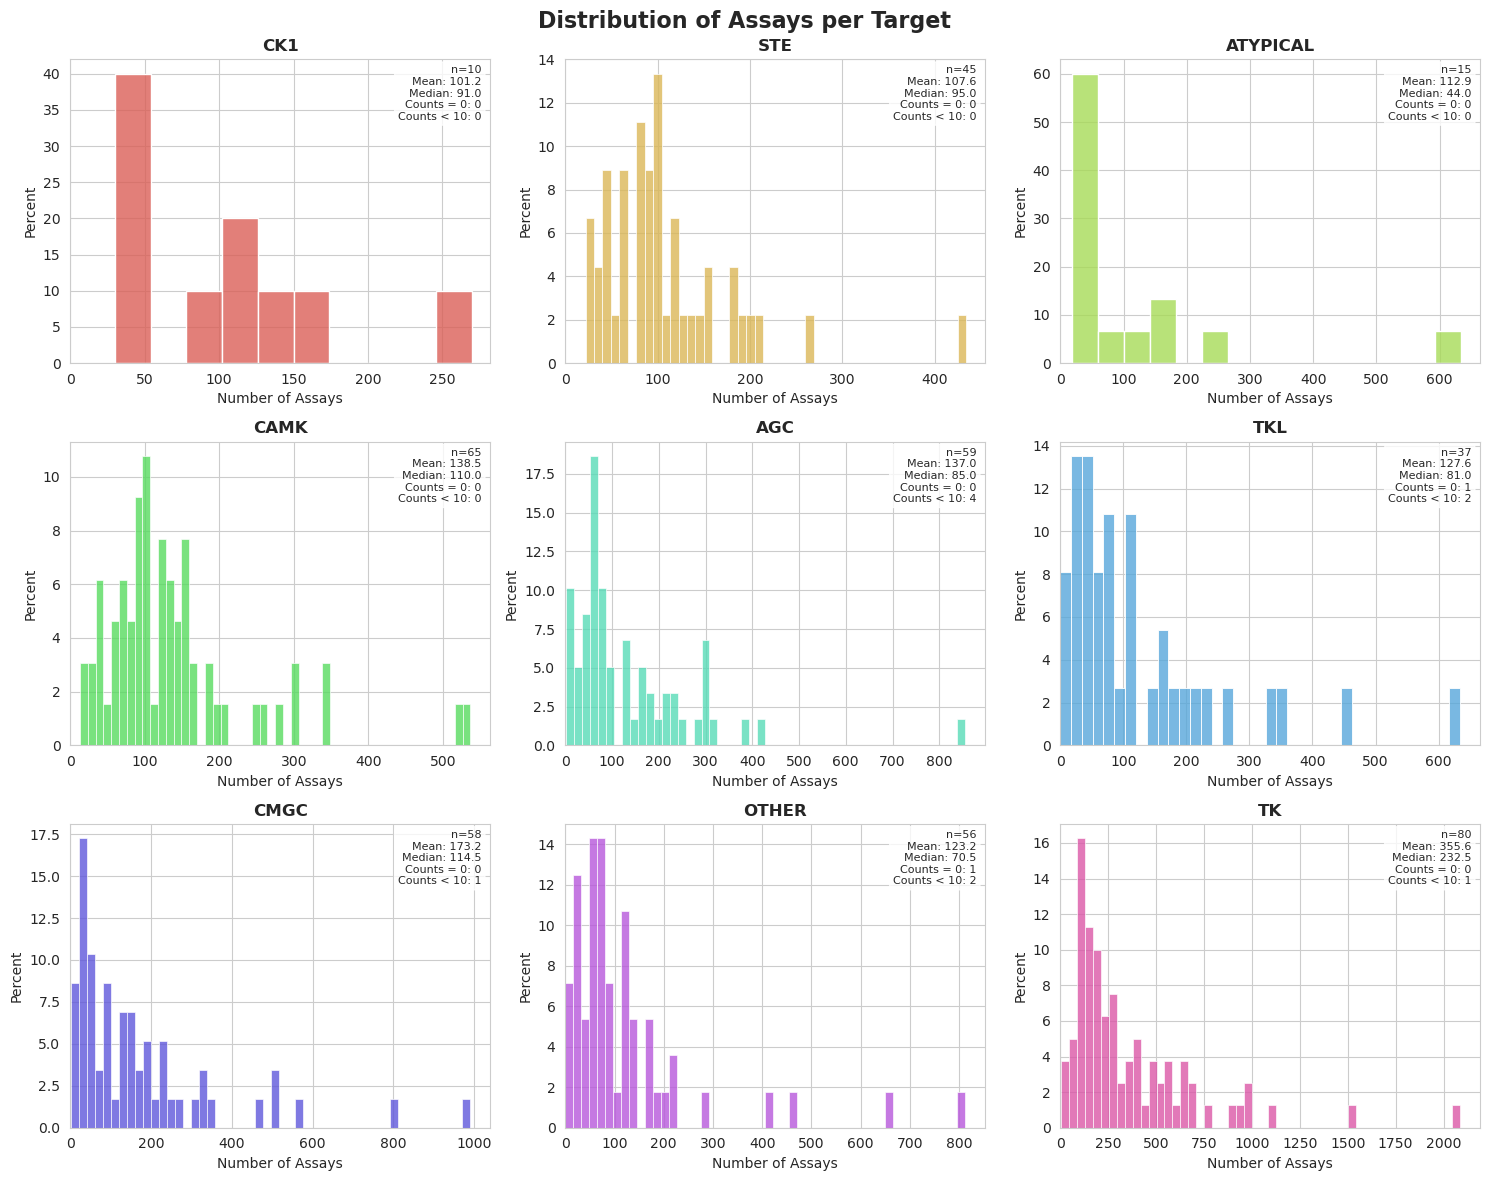

In [158]:
# plot distribution of assays per target, color-coded by group membership
title = "Distribution of Assays per Target"
plot_multi_hist(ta_df, cluster_order, count_col="assay_count", xlabel="Number of Assays", title=title)

In [159]:
tlig_df = target_cluster_df.join(ligand_cluster_df["tid"].value_counts(), on="tid", how="left")
tlig_df = tlig_df.with_columns(
    pl.when(tlig_df["count"].is_null())
    .then(0)
    .otherwise(tlig_df["count"]).alias("count")
)
tlig_df = tlig_df.unique()
tlig_df = tlig_df.rename({"count": "ligand_count"})
assert tlig_df["tid"].n_unique() == target_cluster_df["tid"].n_unique()

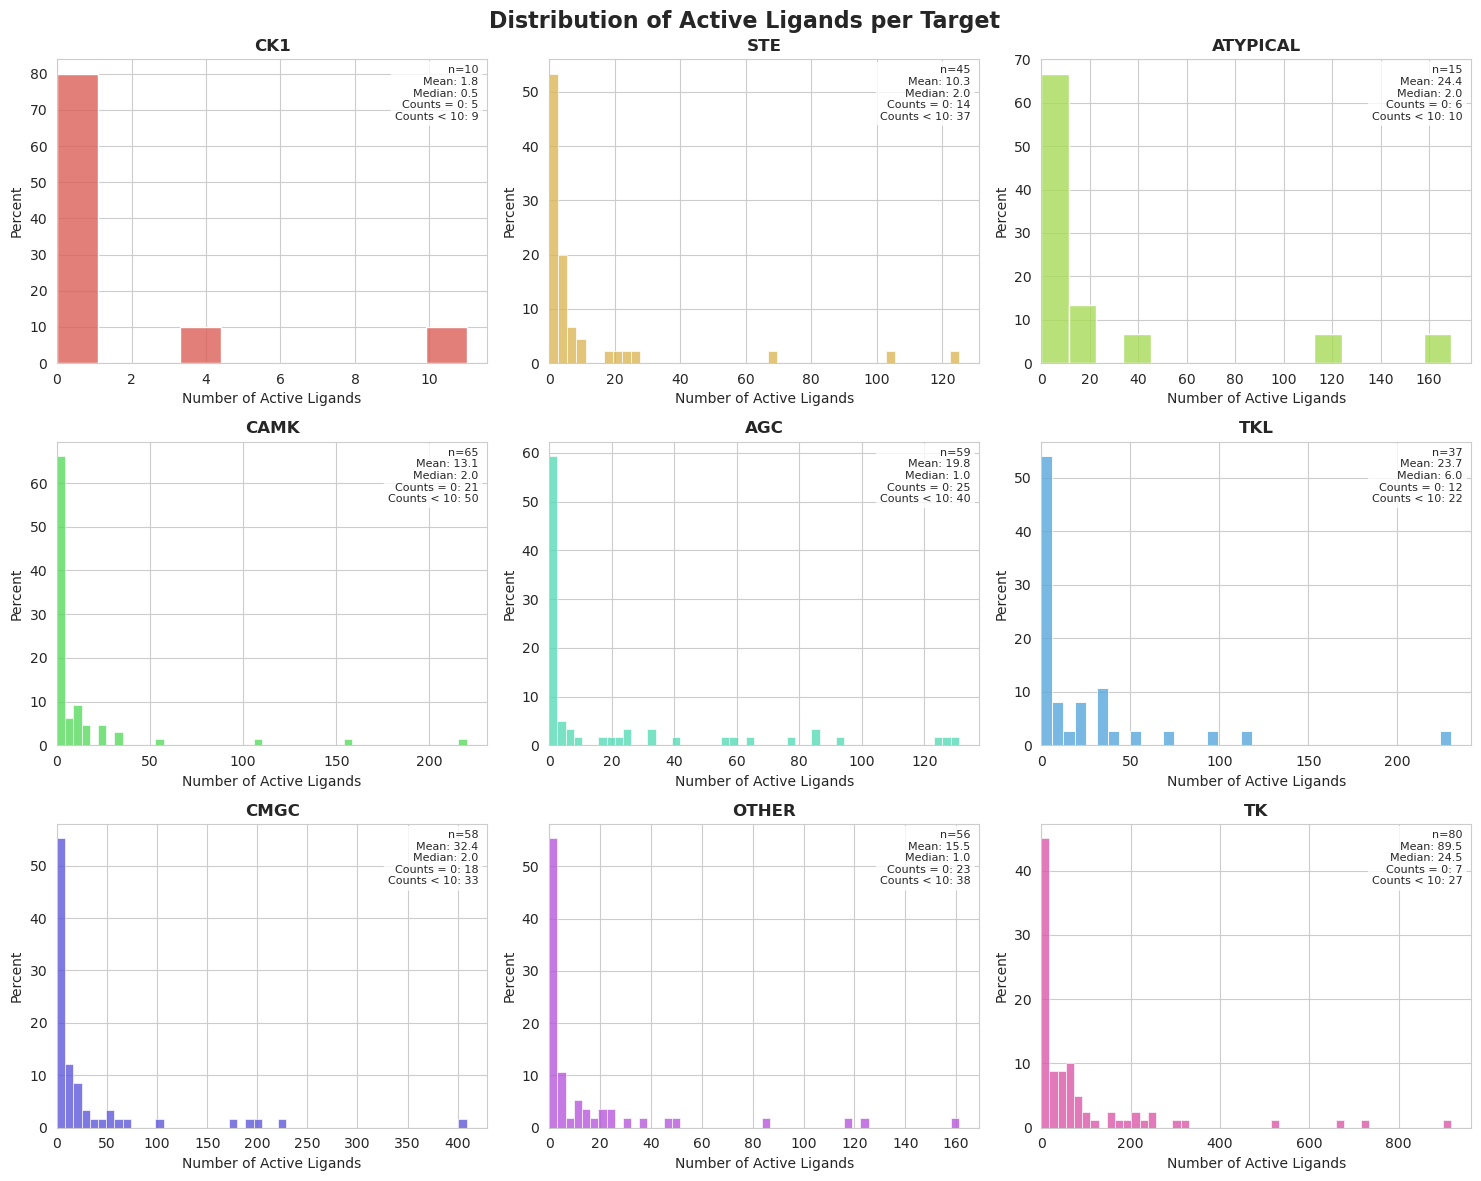

In [160]:
# plot distribution of ligands per target, color-coded by group membership
title = "Distribution of Active Ligands per Target"
plot_multi_hist(tlig_df, cluster_order, count_col="ligand_count", xlabel="Number of Active Ligands", title=title)

In [161]:
tcomb_df = tlig_df.join(ta_df, on="tid")
assert tcomb_df["tid"].n_unique() == target_cluster_df["tid"].n_unique()

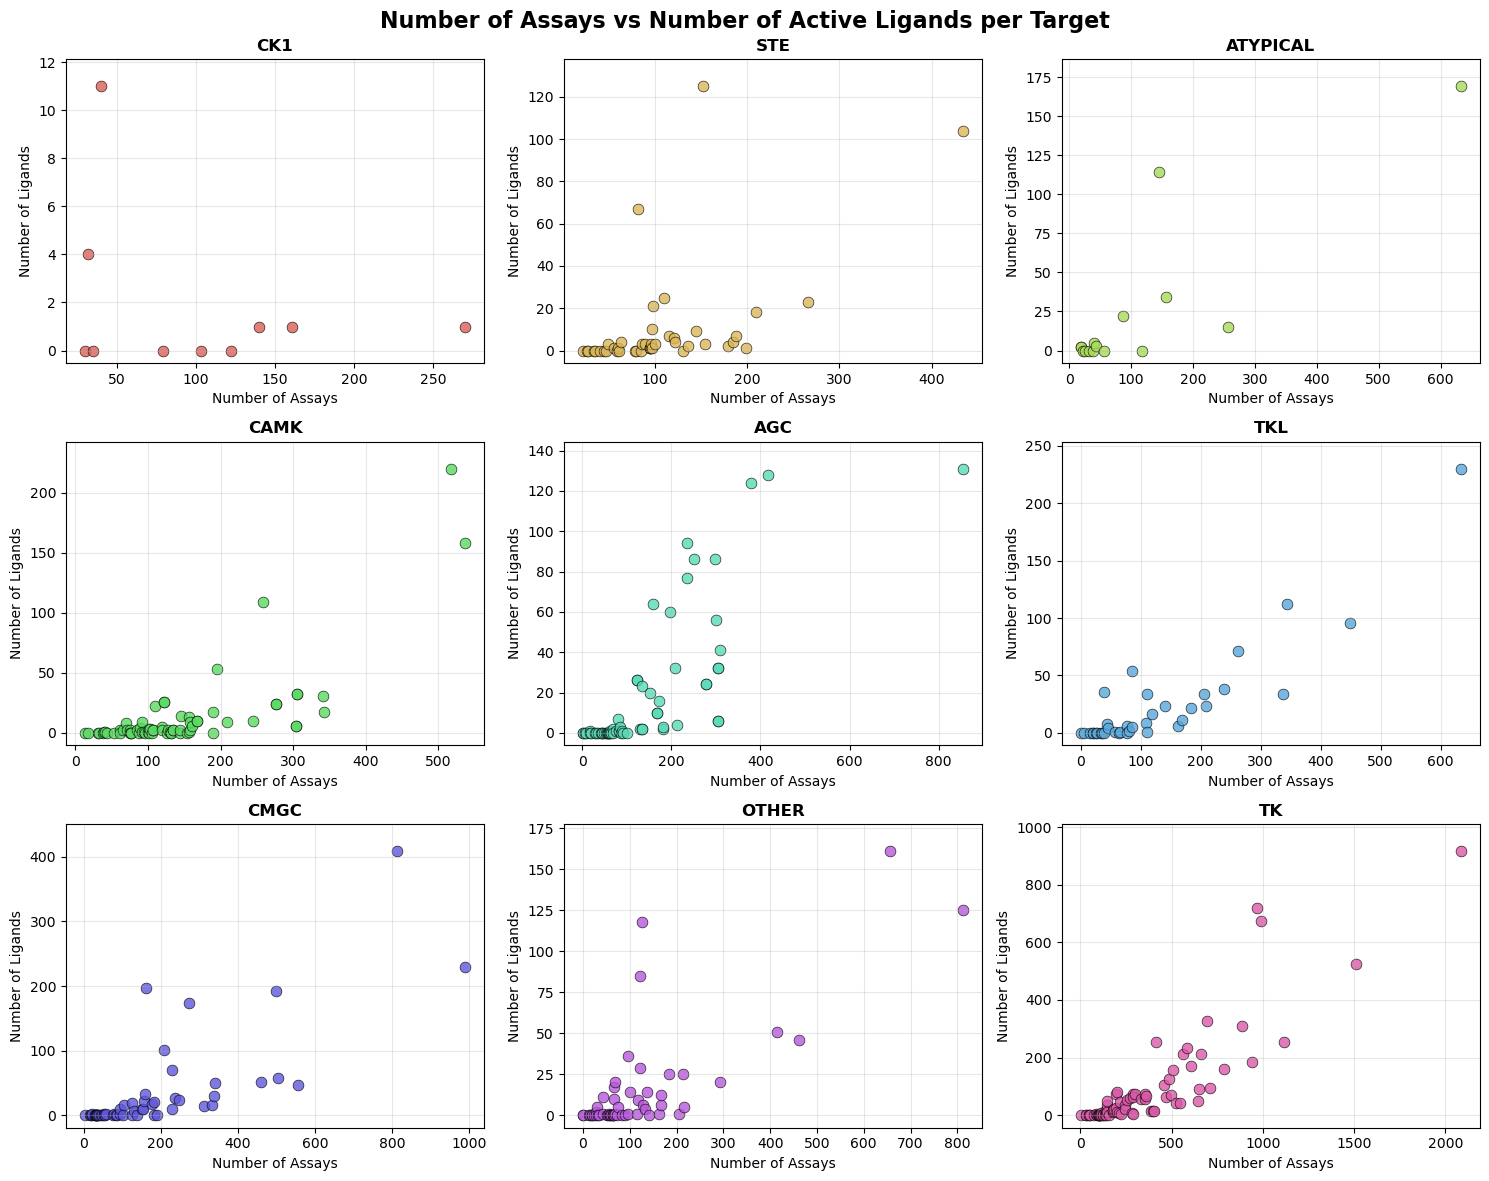

In [ ]:
title = "Number of Assays vs Number of Active Ligands per Target"
create_multi_scatter_plots(tcomb_df, 
                        cluster_order, 
                        x_col="assay_count", 
                        y_col="ligand_count", 
                        xlabel="Number of Assays", 
                        ylabel="Number of Ligands", 
                        title=title,
                        correlation_method=None,
                        show_all_xticks=False,
                        connect_points=False,
                        show_parity_line=False
                        )